## Подключение необходимых для работы библиотек

In [44]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
import openpyxl
from IPython.display import display, Markdown


## Входные данные - население Японии за последние 100 лет

,year,pop
0,1900,43847000
1,1905,46620000
2,1910,49184000
3,1915,52752000
4,1920,55963000
5,1925,59737000
6,1930,64450000
7,1935,68662000
8,1940,71540000
9,1945,72410000


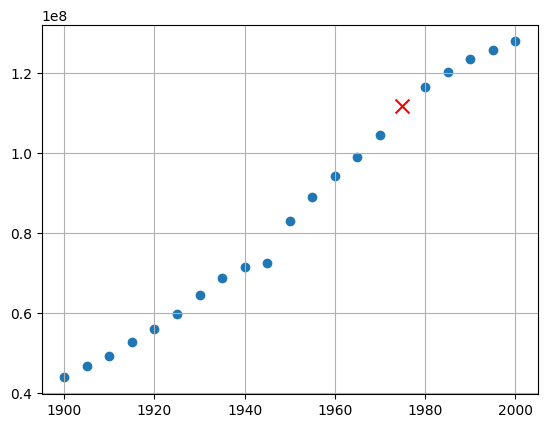

In [49]:
population = pd.read_excel('population.xlsx')
display(population)

x = np.array(population['year'])
y = np.array(population['pop'])
deleted = 15
start = 0
end = 20

x_use = np.delete(x, deleted)[start:end]
y_use = np.delete(y, deleted)[start:end]
lin = np.linspace(min(x_use), max(x_use), 200)

plt.scatter(x_use, y_use)
plt.scatter(x[deleted], y[deleted], marker='x', s=100, color='red')

plt.grid()


## Метод наименьших квадратов

In [42]:
arr2d = np.array([[1, 2, 3],
                  [4, 5, 6]])
arr1d = np.array([1, 2, 3])

display(np.matmul(arr2d, arr1d))
display(np.dot(arr2d, arr1d))

display(np.matmul(arr2d, arr2d.T))


array([14, 32])

array([14, 32])

array([[14, 32],
       [32, 77]])

Reference: 1.116e+08
Interpolation: 1.069e+08
Error: -4.7e+06 (4.18%)


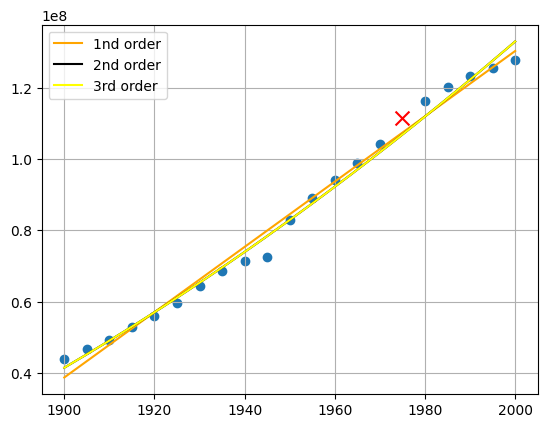

In [50]:
phi1 = np.array([
    lambda x: 1,
    lambda x: x,
])

phi2 = np.array([
    lambda x: 1,
    lambda x: x,
    lambda x: x**2,
])

phi3 = np.array([
    lambda x: 1,
    lambda x: x,
    lambda x: x**2,
    lambda x: x**3,
])

def leastSquares(x, y, phi):
    dim = len(x)

    phi_im = np.array([[phi_i(x_m) for x_m in x] for phi_i in phi])

    free_i = np.matmul(phi_im, y)
    gram_ij = np.matmul(phi_im, phi_im.T)

    sols_j = np.linalg.solve(gram_ij, free_i)

    return lambda arg: np.array([np.sum([sol_i * phi_i(arg_m) for (sol_i, phi_i) in zip(sols_j, phi)]) for arg_m in np.atleast_1d(arg)])

equ1 = leastSquares(x_use, y_use, phi1)
equ2 = leastSquares(x_use, y_use, phi2)
equ3 = leastSquares(x_use, y_use, phi3)

plt.plot(lin, equ1(lin), c='orange', label='1nd order')
plt.plot(lin, equ2(lin), c='black',  label='2nd order')
plt.plot(lin, equ3(lin), c='yellow', label='3rd order')
plt.scatter(x_use, y_use)
plt.scatter(x[deleted], y[deleted], marker='x', s=100, color='red')

ref = y[deleted]
predict = equ3(x[deleted]).item()
print(f"Reference: {ref:.4g}")
print(f"Interpolation: {predict:.4g}")
print(f"Error: {predict - ref:.2g} ({np.abs((ref - predict) / ref * 100):.2f}%)")

plt.legend()
plt.grid()


## Интерполяционный многочлен в форме Ньютона

Reference: 1.322e+08
Interpolation: 1.537e+08
Error: 2.2e+07 (16.29%)


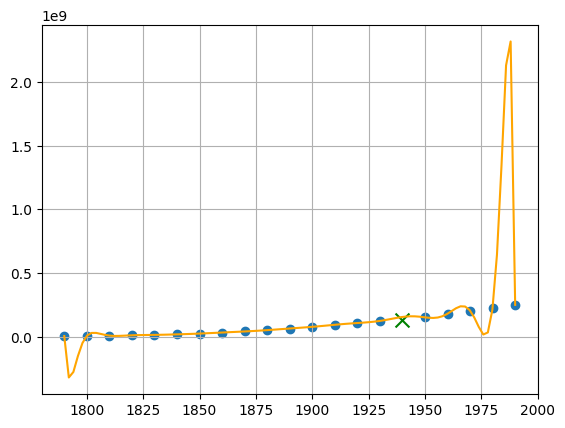

In [46]:
def divided_diff(i, x, f):
    if len(i) == 1:
        return f[0]
    if x[-1] == x[0]:
        return 0
    
    return (divided_diff(i[1:], x[1:], f[1:]) - divided_diff(i[:-1], x[:-1], f[:-1])) / (x[-1] - x[0])

class Newton:
    def __init__(self, x, f):        
        self.values = f
        self.nodes  = x
        self.coeffs = np.array([divided_diff(range(i), self.nodes[:i], self.values[:i]) for i in range(1, len(self.nodes) + 1)])
        
    def __call__(self, x):
        res = 0
        for i in range(len(self.coeffs) - 1, 0, -1):
            res = (res + self.coeffs[i]) * (x - self.nodes[i - 1])
        return res + self.coeffs[0]
    
interp = Newton(x_use, y_use)
t = np.linspace(min(x_use), max(x_use), 100)
plt.plot(t, interp(t))

plt.plot(x_use[15],y_use[15],'ro') 
plt.scatter(x_use, y_use, marker='x', s=100, color='green')

print('Interpolation: {:.0f}'.format(interp(y_use[15])))
print('Real: {:.0f}'.format(y_use[15]))
print('Error: {:.2f} %'.format(100 * abs(y_use[15] - interp(x_use[15])) / y_use[15]))

## Сплайн-интерполяция

Reference: 1.116e+08
Interpolation: 1.106e+08
Error: -9.3e+05 (0.83%)


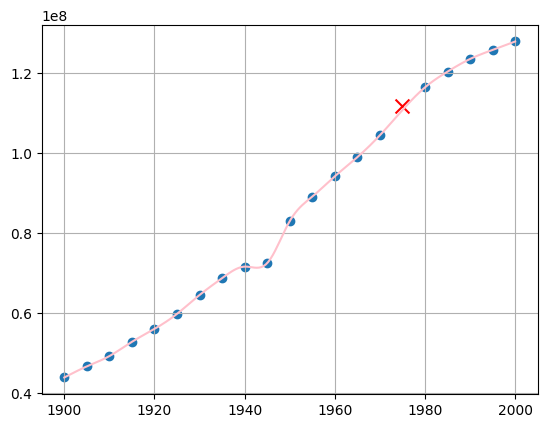

In [51]:
def splineInterp(x, y):
    assert len(x) == len(y), "x and y must have same size"
    dim = len(x)

    h_m = np.zeros(dim)
    for m in range(1, dim):
        h_m[m] = x[m] - x[m-1]

    mu_m = np.zeros(dim)
    for m in range(1, dim - 1):
        mu_m[m] = h_m[m] / (h_m[m] + h_m[m+1])

    lambda_m = 1 - mu_m
    lambda_m[0] = 0

    order = len(x)
    b_im = np.zeros((order, dim))
    b_im[0] = y
    for i in range(1, order):
        prev_m = b_im[i-1]
        b_im[i][0:order-i] = [(prev_m[m+1] - prev_m[m])/(x[m+i] - x[m]) for m in range(0, order - i)]

    b_2m = b_im[2]

    d_m = np.zeros(dim)
    for m in range(1, dim - 1):
        d_m[m] = 6 * b_2m[m-1]

    mat = np.diag(np.full(dim, 2), 0) + np.diag(mu_m[1:], -1) + np.diag(lambda_m[:-1], 1)

    M_m = np.linalg.solve(mat, d_m)

    def poly(arg):
        m = np.searchsorted(x, arg)
        m = np.clip(m, 1, dim-1)
        val = M_m[m-1] * (x[m] - arg)**3 / (6 * h_m[m])                     \
              + M_m[m] * (arg - x[m-1])**3 / (6 * h_m[m])                   \
              + (y[m-1] - M_m[m-1] * h_m[m]**2 / 6) * (x[m] - arg) / h_m[m] \
              + (y[m] - M_m[m] * h_m[m]**2 / 6) * (arg - x[m-1]) / h_m[m]
        return val

    return lambda arg: poly(arg)

equ = splineInterp(x_use, y_use)
plt.plot(lin, equ(lin), c='pink')
plt.scatter(x_use, y_use)
plt.scatter(x[deleted], y[deleted], marker='x', s=100, color='red')

ref = y[deleted]
predict = equ(x[deleted])
print(f"Reference: {ref:.4g}")
print(f"Interpolation: {predict:.4g}")
print(f"Error: {predict - ref:.2g} ({np.abs((ref - predict) / ref * 100):.2f}%)")

plt.grid()
